In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/asan/.Virtualenvs/hypothtest/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'source']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [115]:
import networkx as nx

In [116]:
from hypotest.setup_hypothgraph import convert_to_hypothgraph
from hypotest.graph_generation import hypoth_conf
from hypotest.io import write_dot

# Methodology to assess causal confidence in a hypothesis

In our work we assume that a hypothesis is a directed graph, where nodes are factors, arcs are causal relationships. We focus on causality between two factors $f_1$ and $f_2$.

In [117]:
simple_hypothesis_nodes = [
    ('f1', { 'label': 'f1'}),
    ('f2', { 'label': 'f2'})
]
simple_hypothesis_arcs = [
    ('f1', 'f2', { 'label': 'results in'}),
]
simple_hypothgraph = nx.DiGraph()
simple_hypothgraph.add_nodes_from(simple_hypothesis_nodes)
simple_hypothgraph.add_edges_from(simple_hypothesis_arcs)
simple_hypothgraph = convert_to_hypothgraph.convert_to_hypothgraph(simple_hypothgraph)

In [118]:
source, target = 'f1', 'f2'
conf = hypoth_conf.Hypoth_Conf(source, target, [])

## Simplest case of a causal hypothesis

Let's start with a simplest causal hypothesis $H_0$ where we know that $f_1$ `results in` $f_2$.

In [119]:
import os
from IPython.display import Image
path_to_figures = './images/example'

In [120]:
simplest_dot = os.path.join(path_to_figures, 'simplest.dot')
simplest_png = os.path.join(path_to_figures, 'simplest.png')

with open(simplest_dot, 'w') as f:
    write_dot.hypothgraph_to_dot(simple_hypothgraph, conf, stream=f)

In [121]:
!dot -Tpng -o $simplest_png $simplest_dot

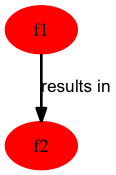

In [122]:
Image(simplest_png)

## Proving a causal hypothesis

In [123]:
from hypotest.stats import confidences

To prove our hypothesis that $f_1$ will eventually cause $f_2$, with the current knowledge, we need to evidence every node which leads us from $f_1$ to $f_2$. Let $\pi(f_1, f_2)$ be a set of all possible paths from $f_1$ to $f_2$.

In this simplest example there is only one path from $f_1$ to $f_2$, the path $\pi_1 = \{f_1, f_2\}$, thus all possible paths $\pi(f_1, f_2) = \{\pi_1\}$.

Thus to prove this hypothesis we need to evidence both $f_1$ and $f_2$. In this simple example let us assume that each node if evidenced gives $+1$ contribution to the confidence in the causal hypothesis. If it is not evidenced then it contributes $0$ to our confidence in the causal hypothesis.

$$
contribution(f_i) = \begin{cases}
1 & \text{ node $f_i$ is evidenced } \\
0 & \text{ node $f_i$ is not evidenced }
\end{cases}
$$

Our total confidence in the causal hypothesis from $f_1$ to $f_2$ is thus 

$$
Confidence(\pi_1) = contribution(f_1) + contribution(f_2),
$$

For any path $\pi_i = \{f_1, f_2, \ldots, f_n\}$, the confidence of this path is

$$
Confidence(\pi_i) = \sum_{f_i \in \pi_i} contribution(f_i)
$$

Finally, confidence in a hypothesis from factor $f_i$ to factor $f_j$ is the sum of contributions of factors in all paths from $f_1$ to $f_2$:

$$
Confidence(H_0, f_i, f_j) = \sum_{\pi_i \in \pi(f_i, f_j)} Confidence(\pi_i).
$$

Now, suppose we had no evidences for neither of the two facts, what would be our confidence in this causal relation (i.e., $contribution(f_1) = contribution(f_2) = 0$)? $0$. By extension, it should be $2$ if we evidence all the nodes, which lead from $f_1$ to $f_2$. If we had evidenced only one of the two, then our confidence would be $1$, assuming that both $f_1$ and $f_2$ are equally important for the causal relation `results in`.

In [124]:
simplest_confidences_unorm = confidences.confidence_spectrum(simple_hypothgraph, source, target)

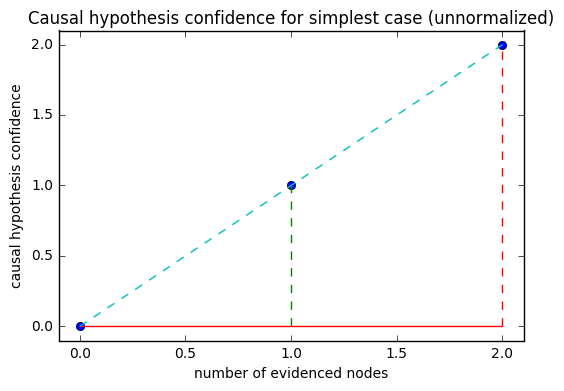

In [125]:
x = range(len(simplest_confidences_unorm))
y = simplest_confidences_unorm
simplest_fig = plt.figure('1')
plt.subplot('111')
plt.xlim(min(x)-0.1, max(x)+0.1)
plt.ylim(min(y)-0.1, max(y)+0.1)
plt.stem(x, y, '--')
plt.plot(x, y, '--')
plt.xlabel('number of evidenced nodes')
plt.ylabel('causal hypothesis confidence')
plt.legend(loc='upper left')
plt.title('Causal hypothesis confidence for simplest case (unnormalized)')

Thus the maximum confidence we can achieve is $2$, i.e., we could use it to normalize our confidence function, such that its values stay in the $[0, 1]$ range, i.e.,

$$
Confidence'(f_i, f_j) = \frac{Confidence(f_1, f_j)}{max(Confidence(f_i, f_j))}
$$

From now on, we always consider the normalized confidence for other hypothesis graphs.

In [126]:
simplest_confidences = confidences.confidence_spectrum(simple_hypothgraph, source, target, normalized=True)

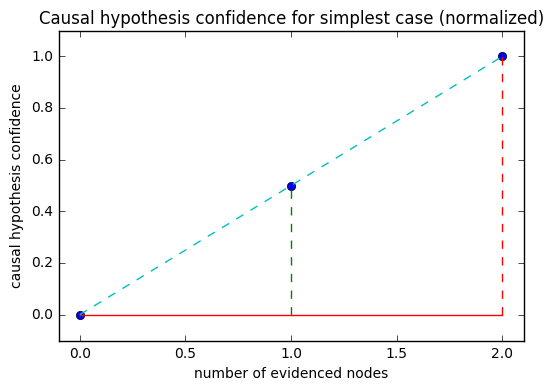

In [153]:
x = range(len(simplest_confidences))
y = simplest_confidences
simplest_fig = plt.figure('1')
plt.subplot('111')
plt.xlim(min(x)-0.1, max(x)+0.1)
plt.ylim(min(y)-0.1, max(y)+0.1)
plt.stem(x, y, '--')
plt.plot(x, y, '--')
plt.xlabel('number of evidenced nodes')
plt.ylabel('causal hypothesis confidence')
plt.legend(loc='upper left')
plt.title('Causal hypothesis confidence for simplest case (normalized)')

## More background knowledge on causal shypothesis

Now, let us imagine that our knowledge of the causal hypothesis is expanded to $H_n$. Namely, we discover that there might be other factors which might have caused $f_2$, and that are related to $f_1$. Suppose, additional knowledge is synthesized in the following augmented hypothesis graph.

In [128]:
augmented_hypothgraph = simple_hypothgraph.copy()
augmented_nodes = [
    ('f3', { 'label': 'f3'}),
    ('f4', { 'label': 'f4'})
]
augmented_arcs = [
    ('f1', 'f3', { 'label': 'results in' }),
    ('f3', 'f4', { 'label': 'results in'}),
    ('f4', 'f2', { 'label': 'results in'})
]

augmented_hypothgraph.add_nodes_from(augmented_nodes)
augmented_hypothgraph.add_edges_from(augmented_arcs)

In [129]:
augmented_dot = os.path.join(path_to_figures, 'augmented.dot')
augmented_png = os.path.join(path_to_figures, 'augmented.png')

with open(augmented_dot, 'w') as f:
    write_dot.hypothgraph_to_dot(augmented_hypothgraph, conf, stream=f)

In [130]:
!dot -Tpng -o $augmented_png $augmented_dot

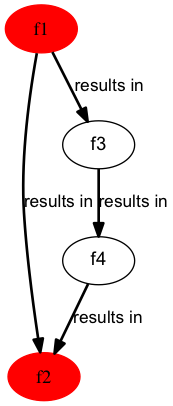

In [131]:
Image(augmented_png)

At this point, our causal hypothesis that $f_1$ causes $f_2$ has additional knowledge, namely, we have $f1$ could have caused $f_2$, by additional causal relations between factors $f_3, f_4$. 

Since, we have to causality paths from $f_1$ to $f_2$, to prove it, we need to evidence every factor which lies in one of the paths from $f_1$ to $f_2$. Thus, we need to evidence $4$ factors, instead of $2$ previously. 

### Augmented hypothesis confidence computation

Unnormalized confidence is essentially the sum of all weighted paths between $f_1$ and $f_2$, where each node is weighted by $Contribution$ function.

In [148]:
augmented_confidences_unnorm = confidences.confidence_spectrum(augmented_hypothgraph, source, target)

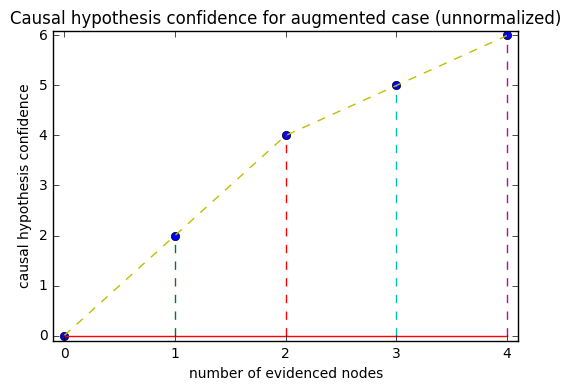

In [149]:
augmented_fig_unnorm = plt.figure('3')
x = range(len(augmented_confidences_unnorm))
y = augmented_confidences_unnorm
plt.subplot('111')
plt.xlim(min(x)-0.1, max(x)+0.1)
plt.ylim(min(y)-0.1, max(y)+0.1)
plt.stem(x, y, '--')
plt.plot(x, y, '--')
plt.xlabel('number of evidenced nodes')
plt.ylabel('causal hypothesis confidence')
plt.legend(loc='upper left')
plt.title('Causal hypothesis confidence for augmented case (unnormalized)')

The normalized confidence function makes sure that we stay in the $[0, 1]$ region.

In [132]:
augmented_confidences = confidences.confidence_spectrum(augmented_hypothgraph, source, target, normalized=True)

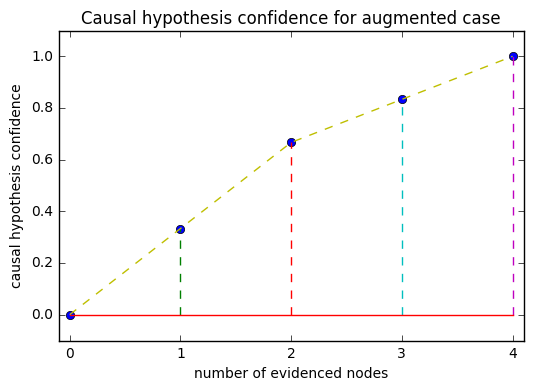

In [133]:
augmented_fig = plt.figure('4')
x = range(len(augmented_confidences))
y = augmented_confidences
plt.subplot('111')
plt.xlim(min(x)-0.1, max(x)+0.1)
plt.ylim(min(y)-0.1, max(y)+0.1)
plt.stem(x, y, '--')
plt.plot(x, y, '--')
plt.xlabel('number of evidenced nodes')
plt.ylabel('causal hypothesis confidence')
plt.legend(loc='upper left')
plt.title('Causal hypothesis confidence for augmented case')

### Relative confidence

Let us say that $H_0$ is our knowledge about the causal hypothesis from $f_1$ to $f_2$, and the $Confidence(H_0)$ is a function which measures our confidence in this hypothesis as we evidence more nodes. Imagine, there exists a universal hypothesis $H_n$, in which the hypothesis causality from $f_1$ to $f_2$ is augmented with the paths as depicted in Figure 2.

In [134]:
augmented_superimposed_dot = os.path.join(path_to_figures, 'augmented_superimposed.dot')
augmented_superimposed_png = os.path.join(path_to_figures, 'augmented_superimposed.png')

with open(augmented_superimposed_dot, 'w') as f:
    write_dot.big_small_to_dot(augmented_hypothgraph, simple_hypothgraph, conf, stream=f)

In [135]:
!dot -Tpng -o $augmented_superimposed_png $augmented_superimposed_dot

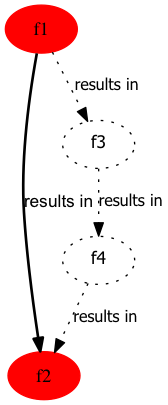

In [136]:
Image(augmented_superimposed_png)

We do not know about the existence of those paths, we evidence nodes which need to be evidenced according to our knowledge $H_0$, but we want to know how would our confidence function be scaled according to the universal hypothesis $H_n$.

In [137]:
relative_simples_to_augmented_confidences = confidences.relative_confidence_spectrum(augmented_hypothgraph, simple_hypothgraph, source, target)
relative_to_me = relative_simples_to_augmented_confidences['sub_confidence_normalized_spectrum']
relative_to_big = relative_simples_to_augmented_confidences['big_confidence_normalized_spectrum']

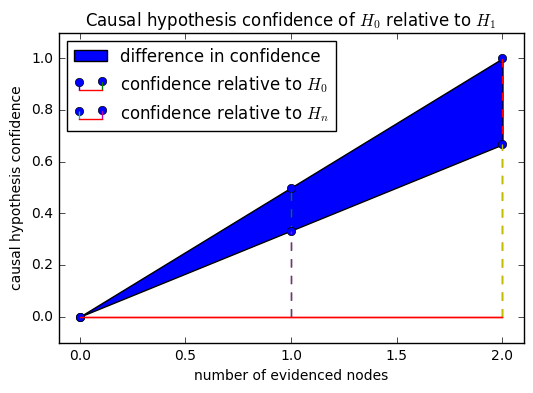

In [138]:
relative_augmented_to_simplest_fig = plt.figure('5')
x = range(len(relative_to_me))
y1 = relative_to_me
y2 = relative_to_big
plt.subplot('111')
plt.xlim(min(x)-0.1, max(x)+0.1)
plt.ylim(min(y1)-0.1, max(y1)+0.1)
plt.stem(x, y1, '--', label='confidence relative to $H_0$')
plt.stem(x, y2, '--', label='confidence relative to $H_n$')
plt.fill_between(x, y1, y2, label="difference in confidence")
plt.xlabel('number of evidenced nodes')
plt.ylabel('causal hypothesis confidence')
plt.legend(loc='upper left')
plt.title('Causal hypothesis confidence of $H_0$ relative to $H_1$')

### Redundant knowledge to hypothesis

Suppose we receive more knowledge that there is a causality relation between $f_4$ and $f_1$, how that would change our confidence in the causal hypothesis from $f_1$ to $f_2$?

In [139]:
redundant_hypothgraph = augmented_hypothgraph.copy()
redundant_arcs = [
    ('f4', 'f1', { 'label': 'results in'} )
]

redundant_hypothgraph.add_edges_from(redundant_arcs)

In [140]:
redundant_dot = os.path.join(path_to_figures, 'redundant.dot')
redundant_png = os.path.join(path_to_figures, 'redundant.png')

with open(redundant_dot, 'w') as f:
    write_dot.hypothgraph_to_dot(redundant_hypothgraph, conf, stream=f)

In [141]:
!dot -Tpng -o $redundant_png $redundant_dot

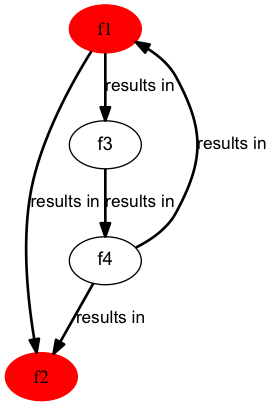

In [142]:
Image(redundant_png)

#### Unnormalized confidence of the redundant graph

In [150]:
redundant_confidences_unnorm = confidences.confidence_spectrum(redundant_hypothgraph, source, target)

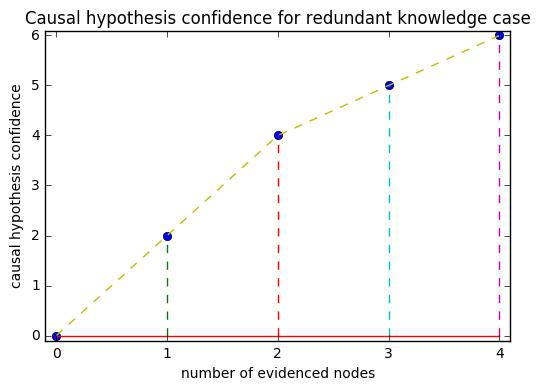

In [151]:
redundant_fig_unnorm = plt.figure('6')
x = range(len(redundant_confidences_unnorm))
y = redundant_confidences_unnorm
plt.subplot('111')
plt.xlim(min(x)-0.1, max(x)+0.1)
plt.ylim(min(y)-0.1, max(y)+0.1)
plt.stem(x, y, '--')
plt.plot(x, y, '--')
plt.xlabel('number of evidenced nodes')
plt.ylabel('causal hypothesis confidence')
plt.legend(loc='upper left')
plt.title('Causal hypothesis confidence for redundant knowledge case')

#### Normalized confidences

In [143]:
redundant_confidences = confidences.confidence_spectrum(redundant_hypothgraph, source, target, normalized=True)

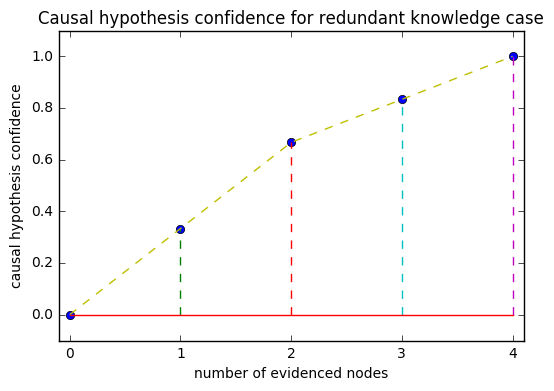

In [144]:
redundant_fig = plt.figure('7')
x = range(len(redundant_confidences))
y = redundant_confidences
plt.subplot('111')
plt.xlim(min(x)-0.1, max(x)+0.1)
plt.ylim(min(y)-0.1, max(y)+0.1)
plt.stem(x, y, '--')
plt.plot(x, y, '--')
plt.xlabel('number of evidenced nodes')
plt.ylabel('causal hypothesis confidence')
plt.legend(loc='upper left')
plt.title('Causal hypothesis confidence for redundant knowledge case')

So the redundant information is not taking into account because there is a cycle in the path $\pi = \{f_1, f_3, f_4\}$.